**<hr>**

# <center>**PROMO TOOL**<br>prototype</center>

**<hr>**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

import sys

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

import datetime
from dateutil.parser import *

from sklearn.pipeline import Pipeline
from transformers import dayName, dummy_days, DFStandardScaler, ZeroFillTransformer, DFFeatureUnion

import pickle

<hr>

# 0. **PREPROCESSING**

## 0.1. Auxiliary functions and lists

### 0.1.1. One Hot Encoding

The function _**ohe**_ takes dataframe and encodes column (actually index) _'date'_ into 7 columns _Day names_ with binary input.

In [2]:
def ohe(self):
    self['day_of_week'] = self.index.get_level_values('date').day_name()
    encoded_columns = pd.get_dummies(self['day_of_week'])
    self = self.join(encoded_columns)
    self = self.drop('day_of_week',axis=1)
    return self

### 0.1.2. Scaling

Before calling the following function we have to provide separate dataframes for train and test data _and_ state the name of the column we want to scale. The function differs test from training data and after the scaler is fitted to train data, it transformes both training and test data. <br> <br> **Later:** improve function so it could 
* take only one dataframe as an argument 
* separate data to test and train data
* store that information 
* finally scale columns like it's described

In [3]:
def scaling_columns_seperately(self_train,self_test,col):
    aux_df = self_train[col]
    std_scaler.fit(aux_df.values.reshape(-1,1))
    aux_df = std_scaler.transform(self_train[col].values.reshape(-1,1))
    self_train[col] = aux_df
    
    aux_df = self_test[col]
    aux_df = std_scaler.transform(self_test[col].values.reshape(-1,1))
    self_test[col] = aux_df

<br>Scaling through each column for an _item_ in a for loop. <br> **Note:** self_train and self_test dataframes have same columns.<br> <br>**Later:** improve the loop (make function) so it could iterate over items (28, ..., 57) --> data is taken from df  **X**.

### 0.1.3. Handling outliers

In this notebook we are dealing with outliers by conducting cross validation:
* remove outliers that are over 95 percentile
* remove outliers that are over 975 percentile
* remove outliers that are over 99 percentile

In [4]:
def removing_outliers(self):
    upper_lim1 = self['amount'].quantile(.95)
    lower_lim1 = self['amount'].quantile(.05)
    self=self[(self['amount'] < upper_lim1) & (self['amount'] > lower_lim1)]
    
    upper_lim2 = self['amount'].quantile(.975)
    lower_lim2 = self['amount'].quantile(.025)
    self=self[(self['amount'] < upper_lim2) & (self['amount'] > lower_lim2)]
    
    upper_lim3 = self['amount'].quantile(.99)
    lower_lim3 = self['amount'].quantile(.01)
    self=self[(self['amount'] < upper_lim3) & (self['amount'] > lower_lim3)]    
    
    return self

### 0.1.4. Separating training and test data

In [5]:
def test_train_separation (self):
    
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train_X = aux.drop('amount',axis=1)
    train_y = aux['amount']
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test_X = aux.drop('amount',axis=1)
    test_y = aux['amount']
    
    return train_X, test_X, train_y, test_y

### 0.1.5. Function and list initialization

In [6]:
std_scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [7]:
list_of_items = [38,39,40,41,57] 

In [8]:
rmse_train = []
rmse_test = []
r2 = []

In [9]:
categorical_features = ['day_of_week']
numerical_features = ['regular_price', 'discounted_price','number_of_stores']

## 0.2. Pipeline

Process:
   * separate dependent array _"amount"_ and _the rest of dataframe_ from the initial dataframe
   * separate data into train and test set
   * fit model on train set
   * transform both train and test set

Defining pipeline with following transformers: DFFeatureUnion, DFStandardScaler, dayName, dummy_days:

In [10]:
#pipeline = Pipeline([ ('features', DFFeatureUnion([       
 #                                                     ('categoricals', Pipeline([ ('dani',dayName()), ('dummyD', dummy_days())]))
 #                                                 ])), 
  #                    ('scaler', DFStandardScaler()) 
   #                ])

Saving pipeline to pipeline_picikle:

In [11]:
#pipeline_pickle_path = 'pipeline_pickle.pkl'
#pipeline_pickle = open (pipeline_pickle_path,'wb')
#pickle.dump(pipeline, pipeline_pickle)
#pipeline_pickle.close()

Loading pipeline from pipeline_pickle:

In [12]:
pipeline_pickle_path = 'pipeline_pickle.pkl'
pipeline_unpickle = open(pipeline_pickle_path, 'rb')
  
pipeline_from_pickle = pickle.load(pipeline_unpickle)

In [13]:
pipeline_from_pickle

Pipeline(memory=None,
         steps=[('features',
                 <transformers.DFFeatureUnion object at 0x000001F86A5E40B8>),
                ('scaler',
                 <transformers.DFStandardScaler object at 0x000001F86A5E4320>)],
         verbose=False)

## 0.3. Data loading

In [200]:
X = pd.read_parquet("C:/Users/vvrhovec/Veronika/kodovi/radni_folder/parquet/X_prices_stores_amount.parquet")

In [201]:
X_38 = X.loc[38]
X_39 = X.loc[39]
X_40 = X.loc[40]
X_41 = X.loc[41]
X_57 = X.loc[57]

**<hr>**

# <center>**ITEMS**</center>

**<hr>**

# 1. ITEM 38

In [16]:
X_38.head()

,regular_price,discounted_price,number_of_stores,amount
date,,,,
2016-01-02,0.1,0.1,439,769.0
2016-01-03,0.1,0.1,436,100.0
2016-01-04,0.1,0.1,441,305.0
2016-01-05,0.1,0.1,441,79.0
2016-01-06,0.1,0.1,444,344.0


## 1.1. Data preprocessing

### 1.1.1. Removing outliers

In [17]:
X_38 = removing_outliers(X_38)

### 1.1.2. Separating data into training and test set

In [202]:
X_38_train, X_38_test, y_38_train, y_38_test =  test_train_separation(X_38)

In [19]:
#X_38_train.to_parquet('X_38_train.parquet')
#X_38_test.to_parquet('X_38_test.parquet')

### 1.1.3. Pipeline

In [203]:
X_38_train = pipeline_from_pickle.fit_transform(X_38_train)
X_38_test = pipeline_from_pickle.transform(X_38_test)

In [21]:
print (X_38_train.shape, y_38_train.shape)
print (X_38_test.shape, y_38_test.shape)

(570, 10) (570,)
(109, 10) (109,)


## 1.2. Fitting and transforming

### 1.2.1. Training set

In [22]:
model_38 = lm.fit(X_38_train, y_38_train)

In [23]:
y_38_train_predicted = model_38.predict(X_38_train)

In [24]:
model_38.score(X_38_train,y_38_train)

0.16219308231894247

In [25]:
mae_38_train = mean_absolute_error(y_38_train, y_38_train_predicted)
mae_38_train

83.72655487973722

In [26]:
mse_38_train = mean_squared_error(y_38_train, y_38_train_predicted)
mse_38_train

10476.359990503172

In [27]:
rmse_38_train = np.sqrt(mean_squared_error(y_38_train, y_38_train_predicted))
rmse_train.append(rmse_38_train)
rmse_38_train

102.35409122503688

### 1.2.2. Test set

In [28]:
y_38_test_predicted = model_38.predict(X_38_test)

In [29]:
mae_38_test = mean_absolute_error(y_38_test, y_38_test_predicted)
mae_38_test

85.5111689078675

In [30]:
mse_38_test = mean_squared_error(y_38_test, y_38_test_predicted)
mse_38_test

10632.707392944762

Text(0, 0.5, 'predicted amount sold')

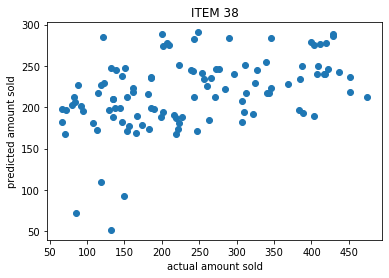

In [31]:
plt.scatter(y_38_test, y_38_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 1.3. Error metrics

In [32]:
r2_score(y_38_test,y_38_test_predicted)

0.14843820292262166

In [33]:
r2.append(r2_score(y_38_test,y_38_test_predicted))

In [34]:
rmse_38_test = np.sqrt(mean_squared_error(y_38_test, y_38_test_predicted))
rmse_test.append(rmse_38_test)
rmse_38_test

103.11502021017482

## Feature Selection
### 1. Univarate Selection

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [36]:
bestFeatures = SelectKBest(score_func=chi2, k=5)

In [37]:
fit = bestFeatures.fit(X_38_train.abs(),y_38_train.abs())
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_38_train.abs().columns)

In [38]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

In [39]:
featureScores

,Specs,Score
0,regular_price,728.552364
1,discounted_price,728.552364
2,number_of_stores,56.805112
3,Friday,193.031270
4,Monday,209.393899
5,Saturday,235.703308
6,Sunday,209.980749
7,Thursday,238.585722
8,Tuesday,245.505917
9,Wednesday,210.478103


**Note:** In order to use SelectKBest, which uses chi2 stat test, it is necessary for data values to be non-negative which is not the case in our data set. In the example above, feature selection is carried out on the absolute values of df data.

### 2. Feature Importance

Feature Importance gives a score for each feature of data. The higher the score, more important (relevant) the feature, towards the output variable, is.

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

[0.00333911 0.00503404 0.92665426 0.01031353 0.01055531 0.00802052
 0.00506211 0.00811602 0.01070898 0.01219612]


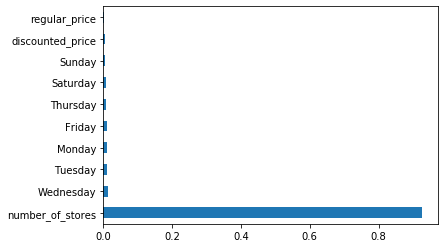

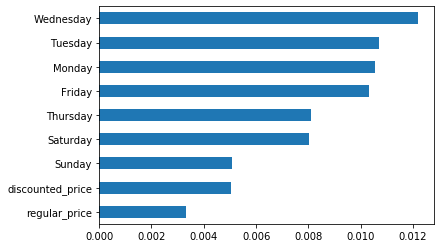

In [41]:
model = ExtraTreesClassifier()
model.fit(X_38_train,y_38_train)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X_38_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
feat_importances.nsmallest(9).plot(kind='barh')
plt.show()

**Note:** Here we can see that prices seem to be the least important features for the model. However, notice that most important feature is _number_of_stores_, just like in the **Univariate Selection.**

### 3. Correlation Matrix with Heatmap

---> Correlation states how the features are related to each other or the target variable

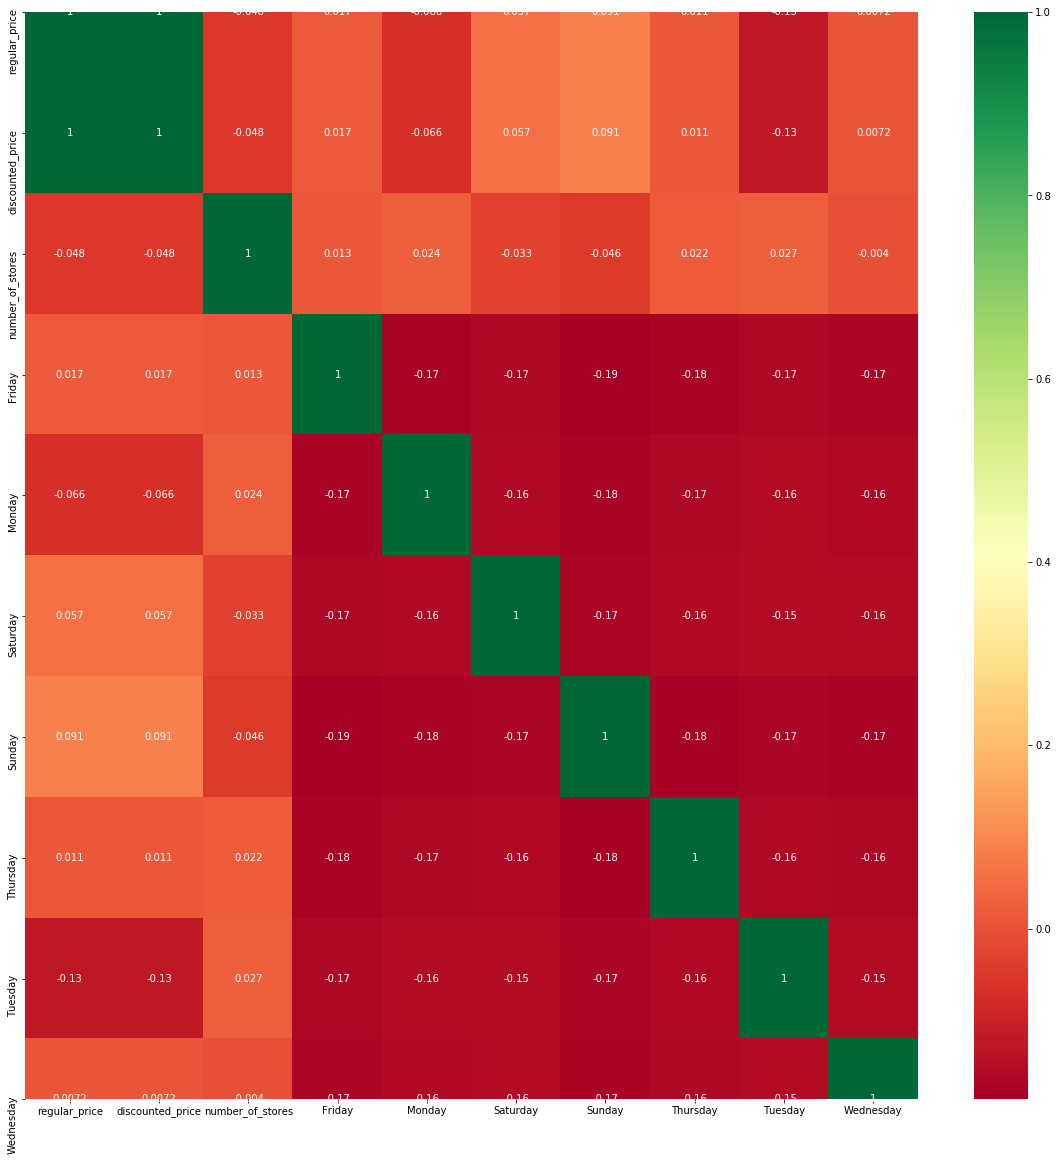

In [42]:
corrmat = X_38_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
 
g = sns.heatmap(X_38_train[top_corr_features].corr(), annot=True, cmap="RdYlGn")

**Note:** Here we see that features regarding prices have highest correlation coefficient, and that _number_of_stores_ is the only other feature correlated with other features with coefficient arround 0.1 

### F_regression
---> f_regression computes the correlation of every feature of X with y

In [43]:
#from sklearn.feature_selection import f_regression

In [ ]:
#pd.concat([f_regression(X_38_train, y_38_train, center = True)[0],f_regression(X_38_train, y_38_train, center = True)[1]],axis=0)

# 2. ITEM 39

In [45]:
X_39.describe()

,regular_price,discounted_price,number_of_stores,amount
count,869.000000,869.000000,869.000000,869.000000
mean,0.099999,0.099999,458.894131,3445.628308
std,0.000034,0.000034,6.215435,1812.797700
min,0.099000,0.099000,423.000000,43.000000
25%,0.100000,0.100000,457.000000,2053.000000
50%,0.100000,0.100000,461.000000,3091.000000
75%,0.100000,0.100000,463.000000,4389.000000
max,0.100000,0.100000,467.000000,10120.000000


## 2.1. Data preprocessing

### 2.1.1. Removing outliers

In [46]:
X_39 = removing_outliers(X_39)

### 2.1.2. Separating data into training and test set

In [47]:
X_39_train, X_39_test, y_39_train, y_39_test =  test_train_separation(X_39)

In [48]:
#X_39_train.to_parquet('X_39_train.parquet')
#X_39_test.to_parquet('X_39_test.parquet')

In [49]:
print (X_39_train.shape, y_39_train.shape)
print (X_39_test.shape, y_39_test.shape)

(594, 3) (594,)
(131, 3) (131,)


### 2.1.3. Pipeline

In [50]:
X_39_train = pipeline_from_pickle.fit_transform(X_39_train)
X_39_test = pipeline_from_pickle.transform(X_39_test)

In [51]:
print (X_39_train.shape, y_39_train.shape)
print (X_39_test.shape, y_39_test.shape)

(594, 10) (594,)
(131, 10) (131,)


## 2.2. Fitting and transforming

### 2.2.1. Training set

In [52]:
model_39 = lm.fit(X_39_train, y_39_train)

In [53]:
y_39_train_predicted = model_39.predict(X_39_train)

In [54]:
model_39.score(X_39_train, y_39_train)

0.22787592381251298

In [55]:
mae_39_train = mean_absolute_error(y_39_train, y_39_train_predicted)
mae_39_train

864.1293276165169

In [56]:
mse_39_train = mean_squared_error(y_39_train, y_39_train_predicted)
mse_39_train

1142736.9707002789

In [57]:
rmse_39_train = np.sqrt(mean_squared_error(y_39_train, y_39_train_predicted))
rmse_train.append(rmse_39_train)
rmse_39_train

1068.9887607923101

### 2.2.2. Test set

In [58]:
y_39_test_predicted = model_39.predict(X_39_test)

In [59]:
mae_39_test = mean_absolute_error(y_39_test, y_39_test_predicted)
mae_39_test

793.8358620908333

In [60]:
mse_39_test = mean_squared_error(y_39_test, y_39_test_predicted)
mse_39_test

939127.3664128917

Text(0, 0.5, 'predicted amount sold')

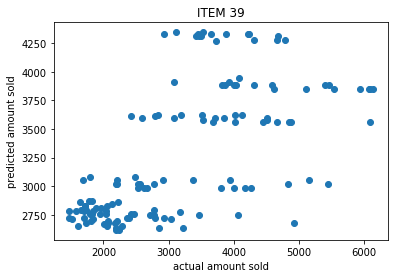

In [61]:
plt.scatter(y_39_test, y_39_test_predicted)
plt.title("ITEM 39")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 2.3. Error metrics

In [62]:
r2_score(y_39_test,y_39_test_predicted)

0.376881315209588

In [63]:
r2.append(r2_score(y_39_test,y_39_test_predicted))

In [64]:
rmse_39_test = np.sqrt(mean_squared_error(y_39_test, y_39_test_predicted))
rmse_test.append(rmse_39_test)
rmse_39_test

969.0858405801272

# 3. ITEM 40

In [65]:
X_40.describe()

,regular_price,discounted_price,number_of_stores,amount
count,869.000000,869.000000,869.000000,869.000000
mean,0.763195,0.684793,315.353280,156.615650
std,0.036849,0.120316,58.894878,115.959738
min,0.539000,0.249000,212.000000,4.000000
25%,0.769000,0.570000,268.000000,82.000000
50%,0.769000,0.769000,304.000000,128.000000
75%,0.770000,0.769000,333.000000,190.000000
max,0.771000,0.782000,450.000000,866.000000


## 3.1. Data preprocessing

### 3.1.1. Removing outliers

In [66]:
X_40 = removing_outliers(X_40)

### 3.1.2. Separating data into training and test set

In [67]:
X_40_train, X_40_test, y_40_train, y_40_test =  test_train_separation(X_40)

In [68]:
#X_40_train.to_parquet('X_40_train.parquet')
#X_40_test.to_parquet('X_40_test.parquet')

### 3.1.3. Pipeline

In [69]:
X_40_train = pipeline_from_pickle.fit_transform(X_40_train)
X_40_test = pipeline_from_pickle.transform(X_40_test)

In [70]:
print (X_40_train.shape, y_40_train.shape)
print (X_40_test.shape, y_40_test.shape)

(599, 10) (599,)
(123, 10) (123,)


## 3.2. Fitting and transforming

### 3.2.1. Training set

In [71]:
model_40 = lm.fit(X_40_train, y_40_train)

In [72]:
y_40_train_predicted = model_40.predict(X_40_train)

In [73]:
model_40.score(X_40_train, y_40_train)

0.43460796591549145

In [74]:
mae_40_train = mean_absolute_error(y_40_train, y_40_train_predicted)
mae_40_train

36.25981860584926

In [75]:
mse_40_train = mean_squared_error(y_40_train, y_40_train_predicted)
mse_40_train

2200.576587072038

In [76]:
rmse_40_train = np.sqrt(mean_squared_error(y_40_train, y_40_train_predicted))
rmse_train.append(rmse_40_train)
rmse_40_train

46.91030363440465

### 3.2.2. Test set

In [77]:
y_40_test_predicted = model_40.predict(X_40_test)

In [78]:
mae_40_test = mean_absolute_error(y_40_test, y_40_test_predicted)
mae_40_test

33.48871118812728

In [79]:
mse_40_test = mean_squared_error(y_40_test, y_40_test_predicted)
mse_40_test

1642.8959880524571

Text(0, 0.5, 'predicted amount sold')

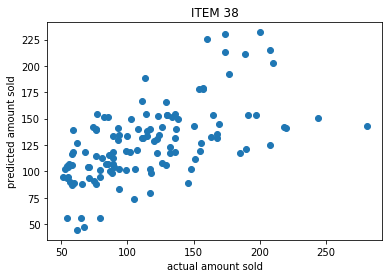

In [80]:
plt.scatter(y_40_test, y_40_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 3.3. Error metrics

In [81]:
r2_score(y_40_test,y_40_test_predicted)

0.2708777548556929

In [82]:
r2.append(r2_score(y_40_test,y_40_test_predicted))

In [83]:
rmse_40_test = np.sqrt(mean_squared_error(y_40_test, y_40_test_predicted))
rmse_test.append(rmse_40_test)
rmse_40_test

40.53265335568913

# 4. ITEM 41

In [84]:
X_41.describe()

,regular_price,discounted_price,number_of_stores,amount
count,867.000000,867.000000,867.000000,867.000000
mean,1.631242,1.619437,124.832757,29.512111
std,0.000605,0.064786,29.843796,15.891616
min,1.630000,1.078000,92.000000,1.000000
25%,1.631000,1.631000,99.000000,18.000000
50%,1.631000,1.631000,115.000000,27.000000
75%,1.632000,1.632000,152.000000,39.000000
max,1.632000,1.705000,185.000000,99.000000


## 4.1. Data preprocessing

### 4.1.1. Removing outliers

In [85]:
X_41 = removing_outliers(X_41)

### 4.1.2. Separating data into training and test set

In [86]:
X_41_train, X_41_test, y_41_train, y_41_test =  test_train_separation(X_41)

In [87]:
#X_41_train.to_parquet('X_41_train.parquet')
#X_41_test.to_parquet('X_41_test.parquet')

### 4.1.3. Pipeline

In [88]:
X_41_train = pipeline_from_pickle.fit_transform(X_41_train)
X_41_test = pipeline_from_pickle.transform(X_41_test)

In [89]:
print (X_41_train.shape, y_41_train.shape)
print (X_41_test.shape, y_41_test.shape)

(593, 10) (593,)
(116, 10) (116,)


## 4.2. Fitting and transforming

### 4.2.1. Training set

In [90]:
model_41 = lm.fit(X_41_train, y_41_train)

In [91]:
y_41_train_predicted = model_41.predict(X_41_train)

In [92]:
model_41.score(X_41_train, y_41_train)

0.4248143182202341

In [93]:
mae_41_train = mean_absolute_error(y_41_train, y_41_train_predicted)
mae_41_train

6.405639661137197

In [94]:
mse_41_train = mean_squared_error(y_41_train, y_41_train_predicted)
mse_41_train

65.31110094420134

In [95]:
rmse_41_train = np.sqrt(mean_squared_error(y_41_train, y_41_train_predicted))
rmse_train.append(rmse_41_train)
rmse_41_train

8.081528379223904

### 4.2.1. Training set

In [96]:
y_41_test_predicted = model_41.predict(X_41_test)

In [97]:
mae_41_test = mean_absolute_error(y_41_test, y_41_test_predicted)
mae_41_test

8.176464216332539

In [98]:
mse_41_test = mean_squared_error(y_41_test, y_41_test_predicted)
mse_41_test

94.42541681745367

Text(0, 0.5, 'predicted amount sold')

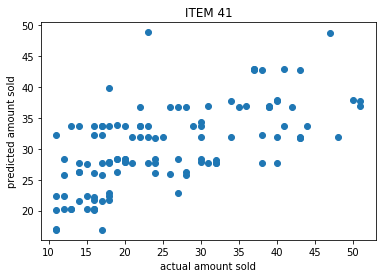

In [99]:
plt.scatter(y_41_test, y_41_test_predicted)
plt.title("ITEM 41")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 4.3. Error metrics

In [100]:
r2_score(y_41_test,y_41_test_predicted)

0.18721407586135785

In [101]:
r2.append(r2_score(y_41_test,y_41_test_predicted))

In [102]:
rmse_41_test = np.sqrt(mean_squared_error(y_41_test, y_41_test_predicted))
rmse_test.append(rmse_41_test)
rmse_41_test

9.717274145430583

# 5. ITEM 57

In [103]:
X_57.describe()

,regular_price,discounted_price,number_of_stores,amount
count,801.000000,801.000000,801.000000,801.000000
mean,0.080722,0.080722,87.906367,60.675406
std,0.002036,0.002036,8.902105,44.194819
min,0.079000,0.079000,70.000000,1.000000
25%,0.080000,0.080000,81.000000,32.000000
50%,0.080000,0.080000,88.000000,52.000000
75%,0.081000,0.081000,94.000000,75.000000
max,0.122000,0.122000,107.000000,372.000000


## 5.1. Data preprocessing

### 5.1.1. Removing outliers

In [187]:
X_57 = removing_outliers(X_57)

### 5.1.2. Separating data into training and test set

In [188]:
X_57_train, X_57_test, y_57_train, y_57_test =  test_train_separation(X_57)

In [106]:
#X_57_train.to_parquet('X_57_train.parquet')
#X_57_test.to_parquet('X_57_test.parquet')

### 5.1.3. Pipeline

In [189]:
X_57_train = pipeline_from_pickle.fit_transform(X_57_train)
X_57_test = pipeline_from_pickle.transform(X_57_test)

In [108]:
print (X_57_train.shape, y_57_train.shape)
print (X_57_test.shape, y_57_test.shape)

(567, 10) (567,)
(89, 10) (89,)


## 5.2. Fitting and transforming

### 5.2.1. Training set

In [109]:
model_57 = lm.fit(X_57_train, y_57_train)

In [110]:
y_57_train_predicted = model_57.predict(X_57_train)

In [111]:
model_57.score(X_57_train, y_57_train)

0.30126234265602037

In [112]:
mae_57_train = mean_absolute_error(y_57_train, y_57_train_predicted)
mae_57_train

15.242815095882987

In [113]:
mse_57_train = mean_squared_error(y_57_train, y_57_train_predicted)
mse_57_train

372.17281998116476

In [114]:
rmse_57_train = np.sqrt(mean_squared_error(y_57_train, y_57_train_predicted))
rmse_train.append(rmse_57_train)
rmse_57_train

19.29178115107998

### 5.2.2. Test set

In [115]:
y_57_test_predicted = model_57.predict(X_57_test)

In [116]:
mae_57_test = mean_absolute_error(y_57_test, y_57_test_predicted)
mae_57_test

17.05650436433873

In [117]:
mse_57_test = mean_squared_error(y_57_test, y_57_test_predicted)
mse_57_test

407.7996867064727

Text(0, 0.5, 'predicted amount sold')

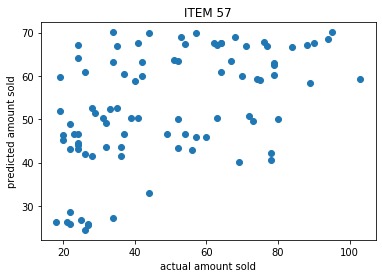

In [118]:
plt.scatter(y_57_test, y_57_test_predicted)
plt.title("ITEM 57")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 5.3. Error metrics

In [119]:
r2_score(y_57_test,y_57_test_predicted)

0.21551156985004483

In [120]:
r2.append(r2_score(y_57_test,y_57_test_predicted))

In [121]:
rmse_57_test = np.sqrt(mean_squared_error(y_57_test, y_57_test_predicted))
rmse_test.append(rmse_57_test)
rmse_57_test

20.1940507750791

# 6. CONCLUSION

In [ ]:
rmse_train

In [ ]:
rmse_test

In [ ]:
r2

In [ ]:
print ("Item","\t: ", "rmse_train","\t \t", "rmse_test","\t\t", "r2")
for i in range(0,len(list_of_items)):
    print (" ",list_of_items[i],"\t: ", rmse_train[i],"\t", rmse_test[i],"\t", r2[i])

## 7. Provjera predikcije za zadnji dan

In [212]:
provjera_38 = X.loc[38]
provjera_39 = X.loc[39]
provjera_40 = X.loc[40]
provjera_41 = X.loc[41]
provjera_57 = X.loc[57]

### 7.1. Data preprocessing

### 7.1.2. Separating data into training and test set

In [213]:
def tt_separation (self):
    aux = self[:-1]
    train_X = aux.drop('amount',axis=1)
    train_y = aux['amount']
    
    return train_X, train_y

In [214]:
X_41_train, y_41_train =  tt_separation(X_41)

In [216]:
X_41_train = pipeline.fit_transform(provjera_38[:-1])

C:\Users\vvrhovec\Veronika\kodovi\radni_folder\transformers.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['day_of_week'] = X.index.get_level_values('date').day_name()


In [217]:
X_41_test = pipeline.transform(provjera_38[provjera_38.shape[0]-1:])

C:\Users\vvrhovec\Veronika\kodovi\radni_folder\transformers.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['day_of_week'] = X.index.get_level_values('date').day_name()


ValueError: operands could not be broadcast together with shapes (1,5) (11,) (1,5) 

In [209]:
y_41_test

date
2018-05-31    47.0
Name: amount, dtype: float64

In [194]:
X_38_train, X_38_test, y_38_train, y_38_test =  tt_separation(provjera_38)
X_38_train = pipeline.fit_transform(X_38_train)
X_38_test = pipeline.transform(X_38_test)

ValueError: operands could not be broadcast together with shapes (1,4) (10,) (1,4) 

### 7.1.3. Pipeline

In [184]:
pipeline = Pipeline(
    [   ('features', DFFeatureUnion([    ('categoricals', Pipeline([ ('dani',dayName()), ('dummyD', dummy_days())]))    ])), 
        ('scaler', DFStandardScaler()) 
    ])

ValueError: operands could not be broadcast together with shapes (1,4) (10,) (1,4) 

## 3.2. Fitting and transforming

### 7.2.1. Training set

In [146]:
model_38 = lm.fit(X_38_train, y_38_train)
model_39 = lm.fit(X_39_train, y_39_train)
model_40 = lm.fit(X_40_train, y_40_train)
model_41 = lm.fit(X_41_train, y_41_train)
model_57 = lm.fit(X_57_train, y_57_train)

In [147]:
y_38_train_predicted = model_38.predict(X_38_train)
y_39_train_predicted = model_39.predict(X_39_train)
y_40_train_predicted = model_40.predict(X_40_train)
y_41_train_predicted = model_41.predict(X_41_train)
y_57_train_predicted = model_57.predict(X_57_train)

In [162]:
y_38_train_predicted

array([ 1.63964346e+14,  3.02855570e+13, -3.28530154e+13,  3.48346811e+13,
       -6.37691288e+13, -4.78135574e+13, -9.44413325e+13,  1.63964346e+14,
        3.02855570e+13, -3.28530154e+13, -6.37691288e+13, -4.78135574e+13,
       -9.44413325e+13,  1.63964346e+14,  3.02855570e+13, -3.28530154e+13,
        3.48346811e+13, -4.78135574e+13, -9.44413325e+13,  1.63964346e+14,
        3.02855570e+13, -3.28530154e+13,  3.48346811e+13, -6.37691288e+13,
       -4.78135574e+13, -9.44413325e+13,  1.63964346e+14,  3.02855570e+13,
       -3.28530154e+13,  3.48346811e+13, -6.37691288e+13, -4.78135574e+13,
       -9.44413325e+13,  1.63964346e+14,  3.02855570e+13, -3.28530154e+13,
        3.48346811e+13, -6.37691288e+13, -4.78135574e+13, -9.44413325e+13,
        1.63964346e+14,  3.02855570e+13,  3.48346811e+13, -6.37691288e+13,
       -9.44413325e+13,  1.63964346e+14,  3.02855570e+13, -3.28530154e+13,
        3.48346811e+13, -6.37691288e+13, -4.78135574e+13, -9.44413325e+13,
        1.63964346e+14,  

In [148]:
model_38.score(X_38_train, y_38_train)
model_39.score(X_39_train, y_39_train)
model_40.score(X_40_train, y_40_train)
model_41.score(X_41_train, y_41_train)
model_57.score(X_57_train, y_57_train)

0.19952149037493294

In [149]:
np.sqrt(mean_squared_error(y_38_train, y_38_train_predicted))

81993834327849.94

In [150]:
provjera_38

,regular_price,discounted_price,number_of_stores,amount
date,,,,
2016-01-02,0.100,0.100,439,769.0
2016-01-03,0.100,0.100,436,100.0
2016-01-04,0.100,0.100,441,305.0
2016-01-05,0.100,0.100,441,79.0
2016-01-06,0.100,0.100,444,344.0
2016-01-07,0.100,0.100,441,97.0
2016-01-08,0.100,0.100,442,311.0
2016-01-09,0.100,0.100,443,541.0
2016-01-10,0.100,0.100,441,94.0


In [155]:
X_38_test

,regular_price,discounted_price,number_of_stores
date,,,
2018-05-31,0.1,0.1,378
